# 贪婪算法的不同和优化

## 现在将创建不同的 Agent 并统计平均值，后悔值，命中率

In [1]:
from typing import Callable, List, Tuple
import gc

from core import EpsilonDecreasingConfig, GreedyAgent, Rewards, RLEnv
from train import train, AverageMetrics
from algorithms import greedy_average, epsilon_average, epsilon_decreasing_average

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np

from pathlib import Path

import json

In [2]:
SEED: int = 42
MACHINE_COUNT: int = 50
env: RLEnv = RLEnv(machine_count=MACHINE_COUNT, seed=SEED)
COUNT: int = 50
STEPS: int = 10_000
CONVERGENCE_THRESHOLD: float = 0.9
CONVERGENCE_MIN_STEPS: int = 1000
EXPERMENT_DATA_FOLDER: Path = Path.cwd() / "experiment_data"
OPTIMISTIC_TIMES: int = 1
ENABLE_OPTIMISTIC: bool = True

In [3]:
def batch_train(
    count: int,
    greedy_algorithm: Callable[..., int],
    env: RLEnv,
    epsilon_config: EpsilonDecreasingConfig,
    steps: int,
    optimistic_init: bool,
    optimistic_times: int,
    convergence_threshold: float,
    convergence_min_steps: int,
    seed: int,
) -> Tuple[List[GreedyAgent], Rewards, AverageMetrics]:
    """批训练 Agent，传入数量，不同的算法，环境，步数和初始种子即可训练

    Args:
        count (int): 训练数量
        agent (GreedyAgent): 算法 类型
        env (RLEnv): 环境
        steps (int): 步数
        seed (int): 初始种子

    Returns:
        Tuple[List[GreedyAgent], Rewards]: 返回训练后的 agents 和平均后的奖励
    """
    _agents: List[GreedyAgent] = []

    if not callable(greedy_algorithm):
        raise ValueError("算法必须传入一个函数")

    for i in range(count):
        _agents.append(
            GreedyAgent(
                name=greedy_algorithm.__name__,  # type: ignore # 在 callable 这里就已经验证了是一个函数，这里是为了避免 ty 工具误报
                env=env,
                greedy_algorithm=greedy_algorithm,
                epsilon_config=epsilon_config,
                optimistic_init=optimistic_init,
                optimistic_times=optimistic_times,
                convergence_threshold=convergence_threshold,
                convergence_min_steps=convergence_min_steps,
                seed=seed + i,
            )
        )

    agents, reward, metrics = train(_agents, steps)

    return agents, reward, metrics


def plot_metrics_history(agents: List[GreedyAgent], agent_name: str, file_name: str):
    """
    根据训练后的一组 agent 的 metrics_history 绘制指标变化图。

    Args:
        agents (List[GreedyAgent]): 经过训练的 agent 列表。
        agent_name (str): 这组 agent 的名称，用于图表标题。
        file_name (str): 保存的文件名（例如："experiment_result.png"）
    """

    if not agents:
        raise ValueError("Agents 列表为空，无法绘图")

    # 1. 设置字体
    font_path = Path.cwd() / "assets" / "微软雅黑.ttf"
    if font_path.exists():
        font_prop = FontProperties(fname=font_path, size=12)
        title_font_prop = FontProperties(fname=font_path, size=16)
        print("成功加载字体：", font_path)

    else:
        print(f"警告：找不到字体文件 {font_path}，将使用默认字体，中文可能显示为方框。")
        font_prop = FontProperties(size=12)
        title_font_prop = FontProperties(size=16)

    # 2. 准备数据
    num_steps: int = agents[0].steps

    avg_history = {
        "regret": np.zeros(num_steps),
        "regret_rate": np.zeros(num_steps),
        "total_reward": np.zeros(num_steps),
        "optimal_rate": np.zeros(num_steps),
        "convergence_steps": np.zeros(num_steps),
        "convergence_rate": np.zeros(num_steps),
    }

    # 遍历每个时间步
    for step_idx in range(num_steps):
        # 临时存储当前时间步所有 agent 的指标
        step_metrics = {
            "regret": [],
            "regret_rate": [],
            "total_reward": [],
            "optimal_rate": [],
            "convergence_steps": [],
            "convergence_rate": [],
        }
        # 遍历每个 agent
        for agent in agents:
            # agent.metrics_history 的索引与 step_idx 一致
            if step_idx < len(agent.metrics_history):
                metrics_at_step = agent.metrics_history[step_idx][
                    1
                ]  # (Rewards, Metrics, int) -> Metrics
                step_metrics["regret"].append(metrics_at_step.regret)
                step_metrics["regret_rate"].append(metrics_at_step.regret_rate)
                step_metrics["total_reward"].append(sum(metrics_at_step.rewards.values))
                step_metrics["optimal_rate"].append(metrics_at_step.optimal_rate)
                step_metrics["convergence_steps"].append(agent.convergence_steps)
                step_metrics["convergence_rate"].append(1 if agent.convergence_steps > 0 else 0)

        # 计算当前时间步的平均值并存入 avg_history
        for key in avg_history:
            if step_metrics[key]:  # 确保列表不为空
                avg_history[key][step_idx] = np.mean(step_metrics[key])

    steps_axis = np.arange(1, num_steps + 1)

    # 3. 开始绘图
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), dpi=100)
    fig.suptitle(f'"{agent_name}" 算法平均指标变化情况', fontproperties=title_font_prop)

    assert isinstance(axes, np.ndarray)
    axes = axes.flatten()

    plot_config = {
        "regret": "后悔值 (Regret)",
        "regret_rate": "后悔率 (Regret Rate)",
        "total_reward": "累积总奖励 (Total Reward)",
        "optimal_rate": "最优臂选择率 (Optimal Rate)",
        "convergence_steps": "达到收敛时的步数 (Convergence Steps)",
        "convergence_rate": "达到收敛率 (Convergence Rate)",
    }

    for i, (metric_key, title) in enumerate(plot_config.items()):
        ax = axes[i]
        ax.plot(steps_axis, avg_history[metric_key], label=title)
        ax.set_title(title, fontproperties=font_prop)
        ax.set_xlabel("时间步 (Steps)", fontproperties=font_prop)
        ax.set_ylabel("平均值", fontproperties=font_prop)
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.legend(prop=font_prop)

    plt.tight_layout(rect=(0, 0, 1, 0.96))
    plt.show()
    
    if not file_name.endswith(".png"):
        file_name += ".png"
    fig.savefig(EXPERMENT_DATA_FOLDER / file_name)
    print(f"✅ 实验数据已保存至 {file_name}")

def save_experiment_data(
    agents: List[GreedyAgent],
    reward: Rewards,
    metrics: AverageMetrics,
    file_name: str
):
    """
    将实验结果保存为 JSON 文件。
    
    Args:
        agents: 训练后的所有 agent 实例列表
        reward: 平均奖励信息
        metrics: 平均评估指标
        file_name: 保存的文件名（例如："experiment_result.json"）
    """
    
    # 转换 Agents 数据为可序列化的字典
    agents_data = []
    for agent in agents:
        agent_history = [
            {
                "step": step,
                "rewards": {
                    "values": list(rewards.values),
                    "counts": list(rewards.counts),
                    "q_values": list(rewards.q_values),
                },
                "metrics": {
                    "regret": m.regret,
                    "regret_rate": m.regret_rate,
                    "optimal_rate": m.optimal_rate,
                }
            }
            for rewards, m, step in agent.metrics_history
        ]
        
        agents_data.append({
            "name": agent.name,
            "seed": agent.seed,
            "steps": agent.steps,
            "convergence_steps": agent.convergence_steps,
            "history": agent_history,
            "final_rewards": {
                "values": list(agent.rewards.values),
                "counts": list(agent.rewards.counts),
                "q_values": list(agent.rewards.q_values),
            },
            "final_metrics": agent.metric().model_dump() if hasattr(agent.metric(), 'model_dump') else vars(agent.metric()),
        })

    # 构造最终输出的 JSON 数据
    experiment_data = {
        "average_reward": {
            "values": list(reward.values),
            "counts": list(reward.counts),
        },
        "average_metrics": {
            "avg_regret": metrics.avg_regret,
            "avg_regret_rate": metrics.avg_regret_rate,
            "avg_total_reward": metrics.avg_total_reward,
            "avg_optimal_rate": metrics.avg_optimal_rate,
            "avg_convergence_steps": metrics.avg_convergence_steps,
            "avg_convergence_rate": metrics.avg_convergence_rate,
        },
        "agents": agents_data,
    }

    # 写入文件
    if not EXPERMENT_DATA_FOLDER.exists():
        EXPERMENT_DATA_FOLDER.mkdir(parents=True, exist_ok=True)
    with open(EXPERMENT_DATA_FOLDER / file_name, "w", encoding="utf-8") as f:
        json.dump(experiment_data, f, ensure_ascii=False, indent=4)

    print(f"✅ 实验数据已保存至 {file_name}")


## 平均奖励

### 普通贪婪算法

达到收敛时的步数: 3120
达到收敛时的步数: 2960
达到收敛时的步数: 1830
达到收敛时的步数: 1600
达到收敛时的步数: 1470
达到收敛时的步数: 1950
达到收敛时的步数: 2990
达到收敛时的步数: 1740
达到收敛时的步数: 1840
达到收敛时的步数: 1260
达到收敛时的步数: 1400
达到收敛时的步数: 3320
达到收敛时的步数: 1570
达到收敛时的步数: 3480
达到收敛时的步数: 1280
达到收敛时的步数: 1570
达到收敛时的步数: 1690
达到收敛时的步数: 2580
达到收敛时的步数: 2570
达到收敛时的步数: 8070
达到收敛时的步数: 2490
达到收敛时的步数: 1640
达到收敛时的步数: 2690
达到收敛时的步数: 2530
达到收敛时的步数: 2220
达到收敛时的步数: 1600
达到收敛时的步数: 2340
达到收敛时的步数: 3040
达到收敛时的步数: 1280
达到收敛时的步数: 2170
达到收敛时的步数: 1490
达到收敛时的步数: 1880
达到收敛时的步数: 1590
达到收敛时的步数: 1550
达到收敛时的步数: 3100
达到收敛时的步数: 1500
达到收敛时的步数: 1370
达到收敛时的步数: 2240
成功加载字体： /home/Jese__Ki/Projects/learn/Python/rl_atomic/greedy/assets/微软雅黑.ttf


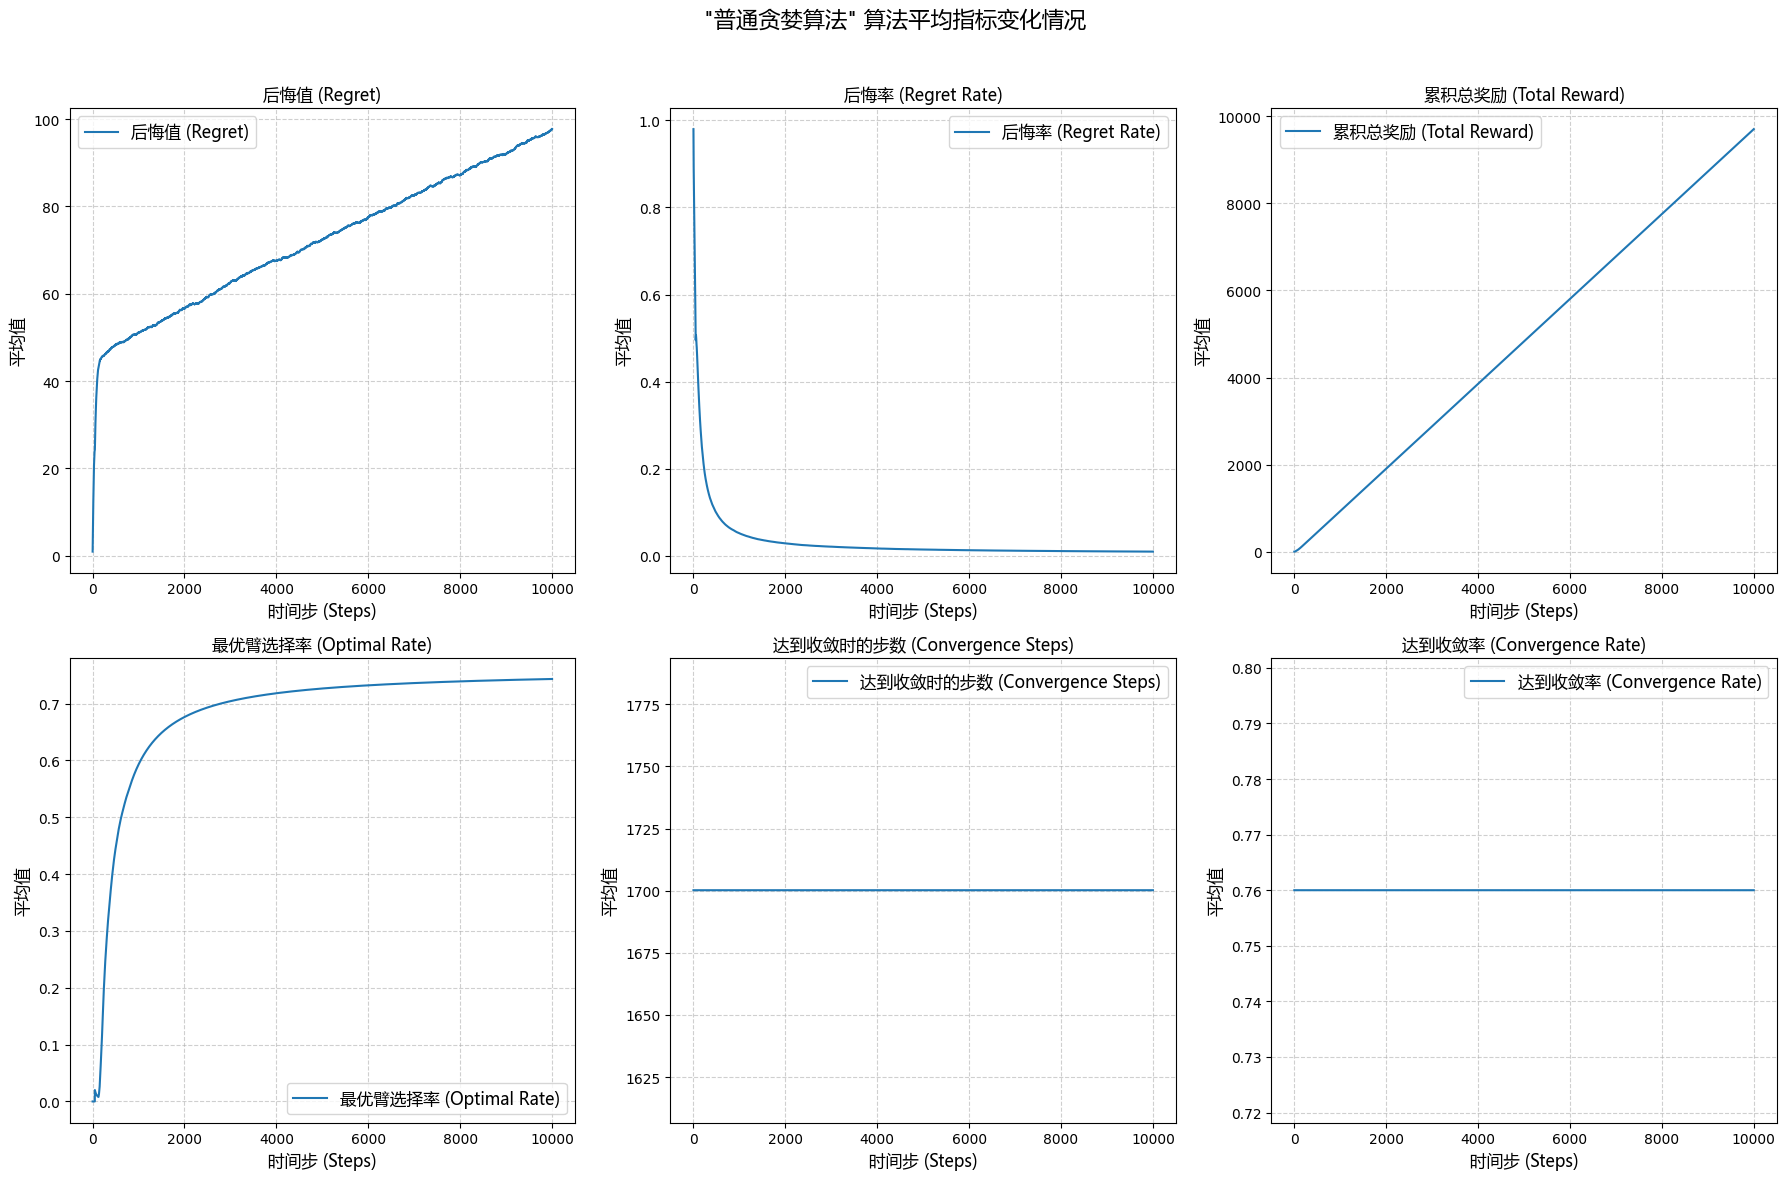

✅ 实验数据已保存至 greedy_average_Q_0=1.png
anget 名称: greedy_average
平均奖励：values=[0.02, 0.08, 0.1, 0.1, 0.18, 0.2, 0.2, 0.22, 0.26, 0.26, 0.3, 0.46, 0.46, 0.5, 0.56, 0.56, 0.66, 0.7, 0.76, 0.86, 0.94, 0.98, 0.98, 1.0, 1.0, 1.06, 1.08, 1.22, 1.36, 1.42, 1.56, 1.68, 2.02, 2.36, 2.62, 2.74, 2.9, 3.04, 3.2, 3.54, 3.6, 4.12, 4.46, 5.4, 6.4, 11.44, 13.06, 224.1, 2102.22, 7287.28] counts=[1.02, 1.08, 1.1, 1.1, 1.18, 1.2, 1.2, 1.22, 1.26, 1.26, 1.3, 1.46, 1.46, 1.5, 1.56, 1.56, 1.66, 1.7, 1.76, 1.86, 1.94, 1.98, 1.98, 2.0, 2.0, 2.06, 2.08, 2.22, 2.36, 2.42, 2.56, 2.68, 3.02, 3.36, 3.62, 3.74, 3.92, 4.04, 4.2, 4.56, 4.6, 5.12, 5.48, 6.42, 7.4, 12.62, 14.26, 238.08, 2189.1, 7432.74] optimistic_init=False optimistic_times=1 q_values=[] q_values_optimistic=[]
指标：AverageMetrics(avg_regret=97.70156862745105, avg_regret_rate=0.009965560000000004, avg_total_reward=9706.22, avg_optimal_rate=0.7432739999999999, avg_convergence_steps=1700.2, avg_convergence_rate=0.76)


22809

In [4]:
# 普通贪婪算法的结果
agents, reward, metrics = batch_train(
    count=COUNT,
    greedy_algorithm=greedy_average,
    env=env,
    epsilon_config=EpsilonDecreasingConfig(),
    steps=STEPS,
    optimistic_init=ENABLE_OPTIMISTIC,
    optimistic_times=OPTIMISTIC_TIMES,
    convergence_threshold=CONVERGENCE_THRESHOLD,
    convergence_min_steps=CONVERGENCE_MIN_STEPS,
    seed=SEED,
)

plot_metrics_history(agents=agents, agent_name="普通贪婪算法", file_name=f"{agents[0].name}_Q_0={OPTIMISTIC_TIMES}.png")

print(f"anget 名称: {agents[0].name}\n平均奖励：{reward}\n指标：{metrics}")
# save_experiment_data(agents=agents, reward=reward, metrics=metrics, file_name=f"{agents[0].name}_Q_0={OPTIMISTIC_TIMES}.json")
del agents, reward, metrics
gc.collect()

### 随机探索贪婪算法

成功加载字体： /home/Jese__Ki/Projects/learn/Python/rl_atomic/greedy/assets/微软雅黑.ttf


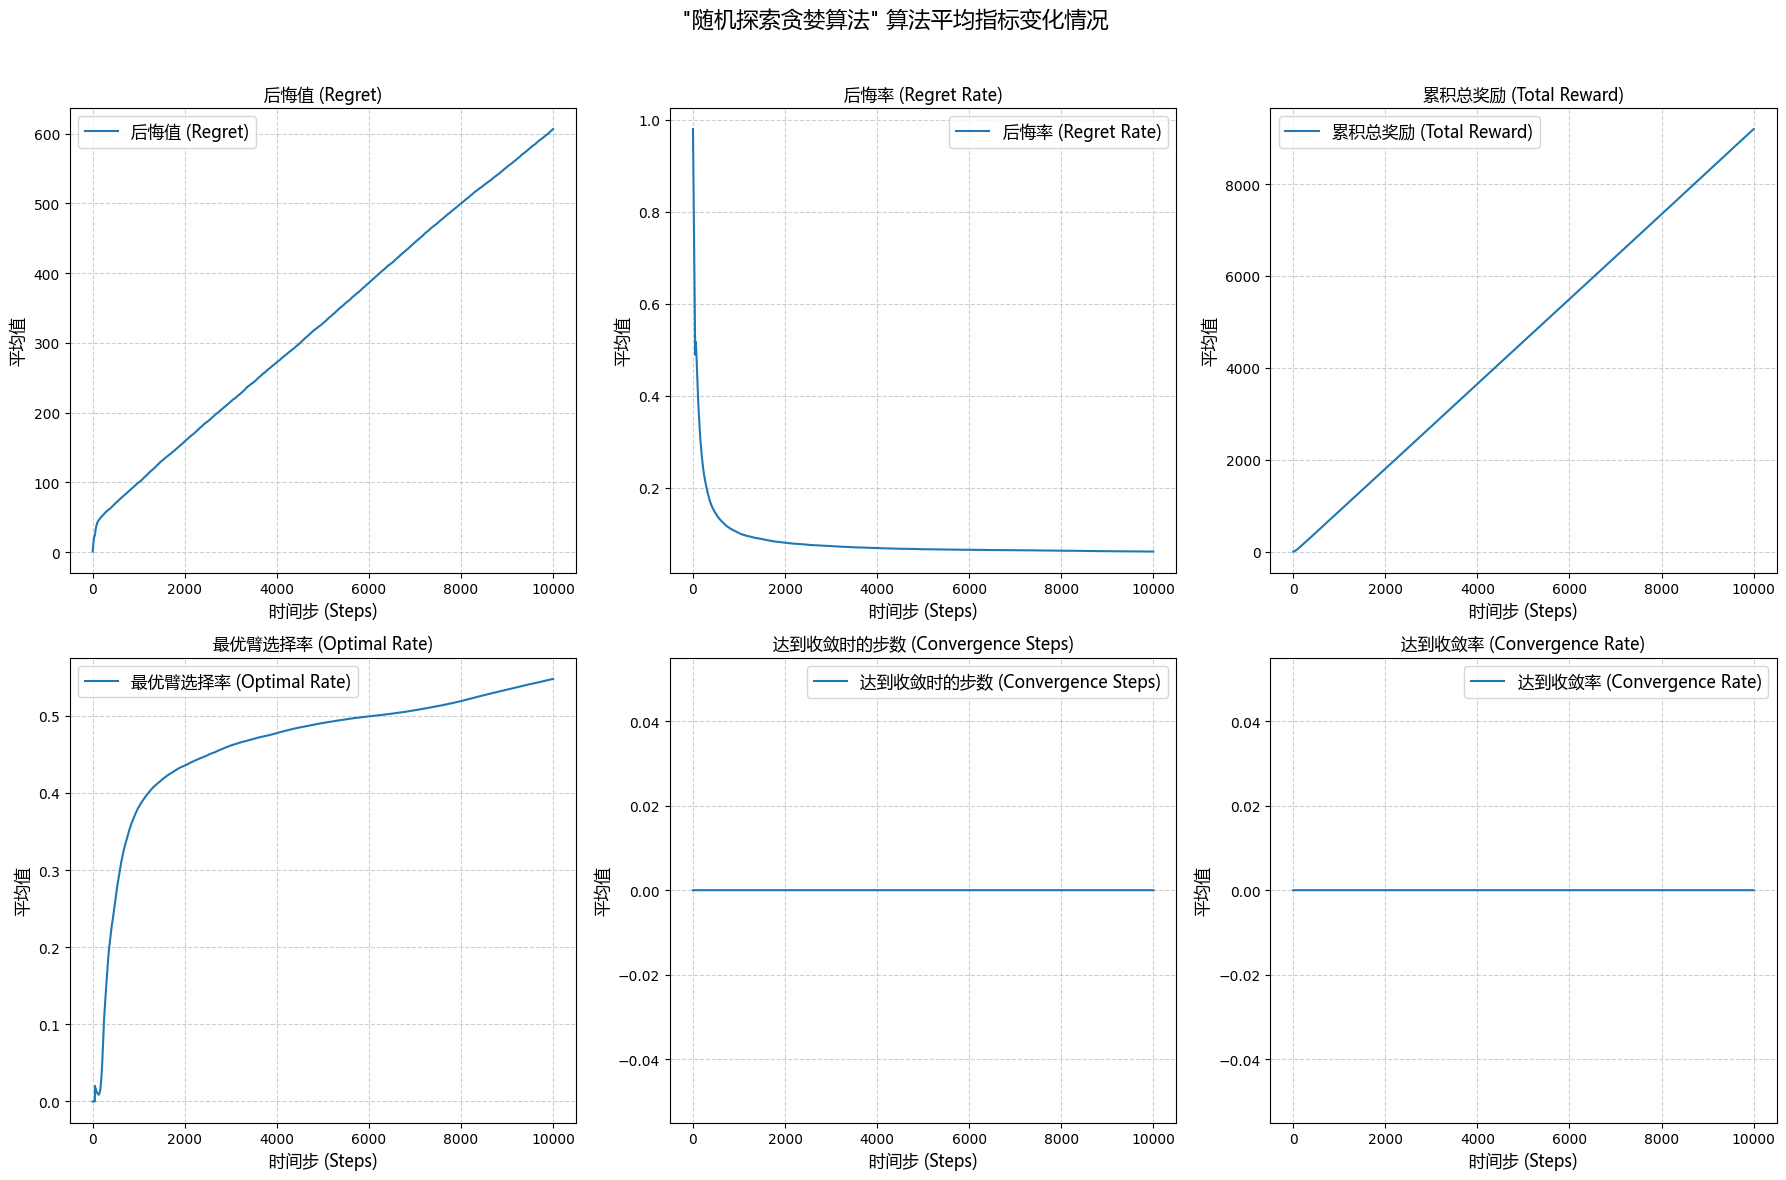

✅ 实验数据已保存至 epsilon_average_Q_0=1.png
anget 名称: epsilon_average
平均奖励：values=[0.36, 0.68, 1.0, 1.42, 1.86, 2.22, 2.92, 3.06, 3.42, 3.9, 4.18, 4.8, 5.32, 6.14, 5.9, 6.44, 6.9, 7.12, 7.4, 8.56, 8.26, 8.94, 8.86, 9.6, 10.4, 10.76, 11.12, 11.62, 12.22, 13.36, 13.18, 14.44, 14.36, 14.02, 16.82, 17.3, 17.26, 17.7, 18.34, 20.64, 21.26, 22.3, 24.82, 24.12, 37.08, 78.06, 40.26, 364.4, 2858.8, 5373.48] counts=[20.42, 20.86, 20.2, 20.28, 20.88, 20.24, 22.08, 20.62, 20.68, 21.54, 20.7, 21.4, 21.52, 22.38, 20.66, 20.92, 21.1, 20.66, 20.96, 23.24, 21.46, 21.58, 20.76, 21.14, 21.84, 21.64, 21.82, 21.8, 21.94, 23.0, 22.18, 23.38, 22.46, 21.36, 24.68, 24.58, 23.94, 23.98, 23.96, 26.32, 26.44, 26.96, 29.16, 27.48, 41.5, 86.26, 43.68, 387.32, 2976.98, 5479.06] optimistic_init=False optimistic_times=1 q_values=[] q_values_optimistic=[]
指标：AverageMetrics(avg_regret=606.541568627451, avg_regret_rate=0.06186724000000001, avg_total_reward=9197.38, avg_optimal_rate=0.547906, avg_convergence_steps=0.0, avg_conver

21610

In [5]:
# 随机探索贪婪算法的结果
agents, reward, metrics = batch_train(
    count=COUNT,
    greedy_algorithm=epsilon_average,
    env=env,
    epsilon_config=EpsilonDecreasingConfig(),
    steps=STEPS,
    optimistic_init=ENABLE_OPTIMISTIC,
    optimistic_times=OPTIMISTIC_TIMES,
    convergence_threshold=CONVERGENCE_THRESHOLD,
    convergence_min_steps=CONVERGENCE_MIN_STEPS,
    seed=SEED,
)

plot_metrics_history(agents=agents, agent_name="随机探索贪婪算法", file_name=f"{agents[0].name}_Q_0={OPTIMISTIC_TIMES}.png")

print(f"anget 名称: {agents[0].name}\n平均奖励：{reward}\n指标：{metrics}")
# save_experiment_data(agents=agents, reward=reward, metrics=metrics, file_name=f"{agents[0].name}_Q_0={OPTIMISTIC_TIMES}.json")
del agents, reward, metrics
gc.collect()

### 退火随机探索贪婪算法

达到收敛时的步数: 4630
达到收敛时的步数: 3210
达到收敛时的步数: 2980
达到收敛时的步数: 3390
达到收敛时的步数: 3160
达到收敛时的步数: 7210
达到收敛时的步数: 3590
达到收敛时的步数: 4590
达到收敛时的步数: 4070
达到收敛时的步数: 3060
达到收敛时的步数: 2940
达到收敛时的步数: 3450
达到收敛时的步数: 4020
达到收敛时的步数: 4100
达到收敛时的步数: 2790
达到收敛时的步数: 4000
达到收敛时的步数: 3330
达到收敛时的步数: 3910
达到收敛时的步数: 3350
达到收敛时的步数: 3220
达到收敛时的步数: 4060
达到收敛时的步数: 7330
达到收敛时的步数: 3640
达到收敛时的步数: 3580
达到收敛时的步数: 3580
达到收敛时的步数: 3640
达到收敛时的步数: 3760
达到收敛时的步数: 3050
达到收敛时的步数: 4870
达到收敛时的步数: 3210
达到收敛时的步数: 3040
达到收敛时的步数: 3420
达到收敛时的步数: 3660
达到收敛时的步数: 3630
成功加载字体： /home/Jese__Ki/Projects/learn/Python/rl_atomic/greedy/assets/微软雅黑.ttf


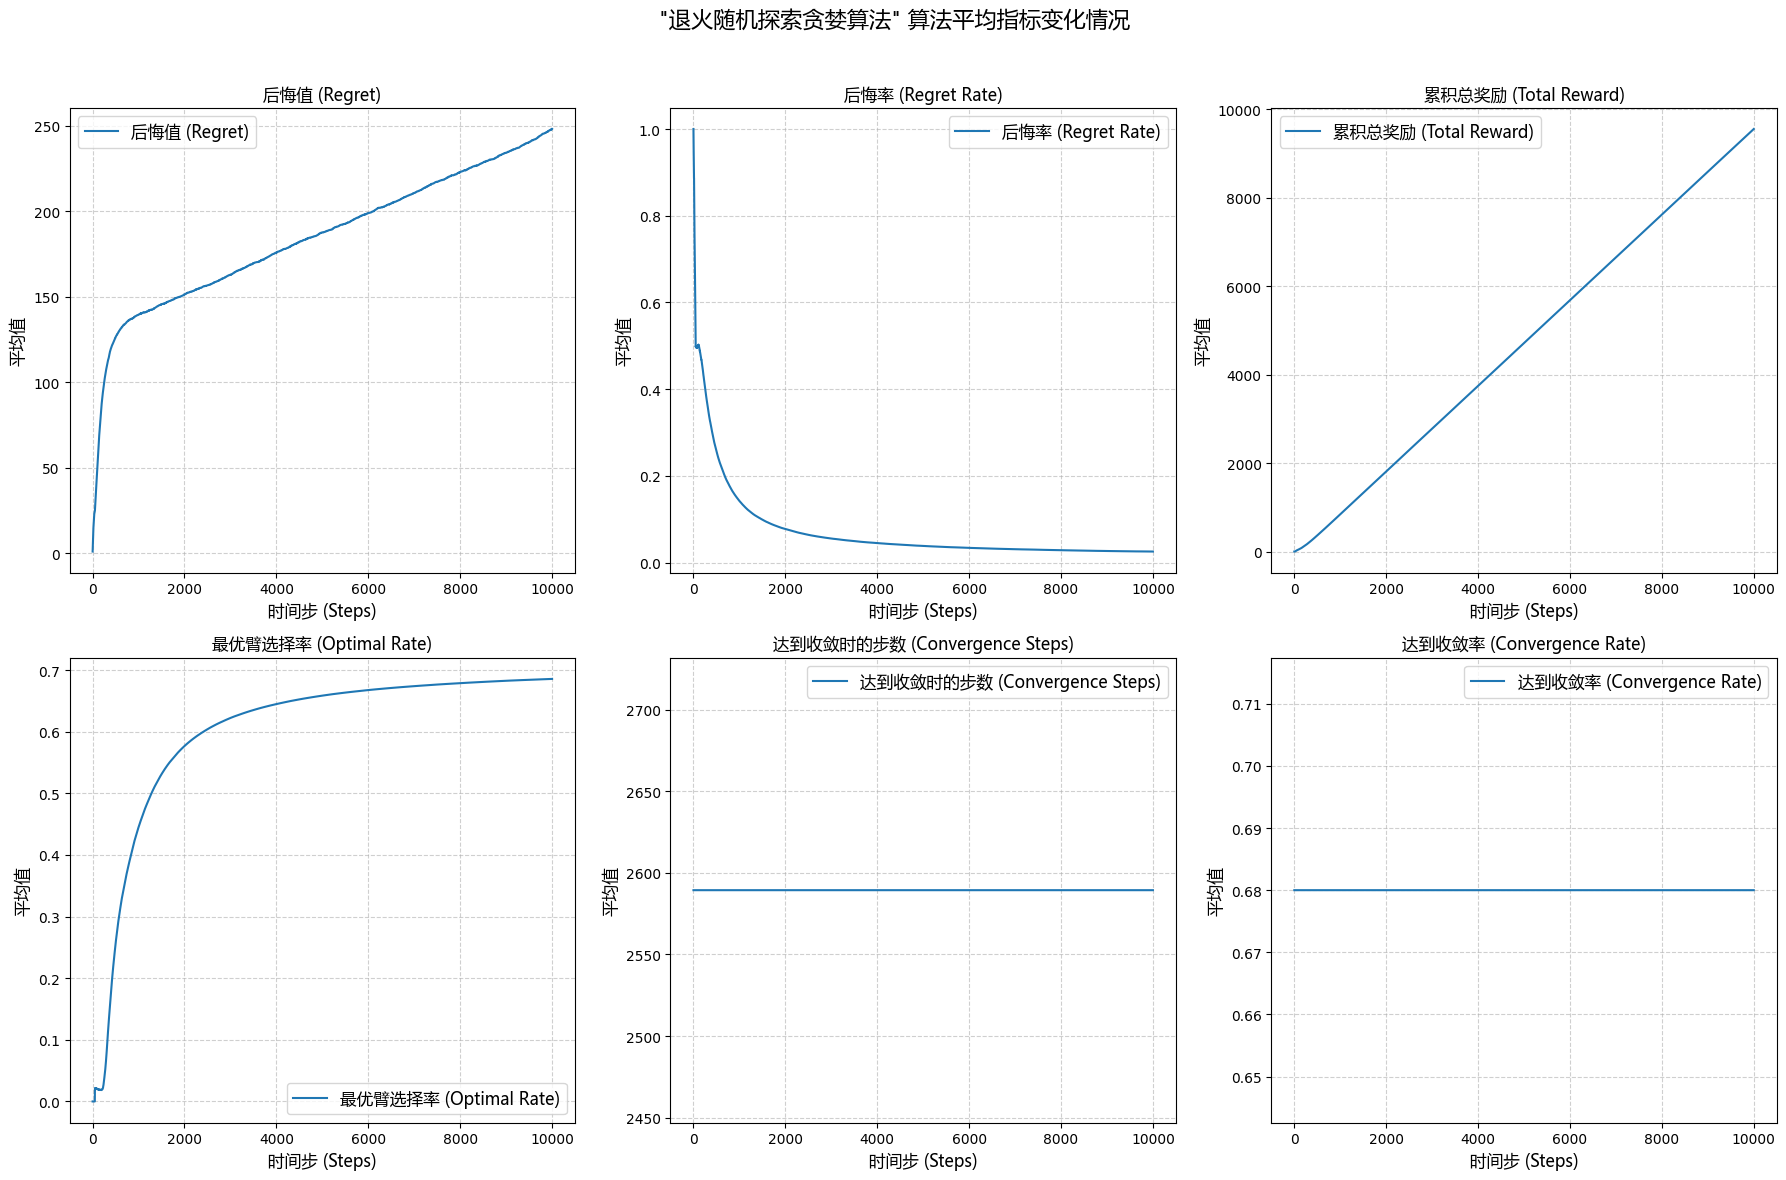

✅ 实验数据已保存至 epsilon_decreasing_average_Q_0=1.png
anget 名称: epsilon_decreasing_average
平均奖励：values=[0.12, 0.26, 0.26, 0.48, 0.58, 0.8, 0.96, 1.14, 1.26, 1.28, 1.42, 1.4, 1.66, 1.64, 1.98, 2.22, 2.5, 2.74, 2.82, 2.96, 2.88, 2.94, 3.38, 3.46, 3.34, 3.84, 3.88, 4.22, 4.08, 4.22, 4.58, 5.16, 4.96, 4.88, 5.68, 5.66, 6.32, 5.7, 6.4, 7.44, 7.7, 8.66, 8.94, 8.72, 12.4, 14.88, 206.26, 560.52, 1881.56, 6724.82] counts=[7.04, 6.84, 6.12, 6.64, 6.24, 6.58, 7.16, 6.86, 6.82, 6.46, 6.76, 6.38, 6.94, 7.14, 6.72, 6.82, 7.84, 7.68, 7.42, 7.7, 7.04, 7.1, 7.22, 7.06, 6.9, 7.58, 7.22, 7.64, 7.16, 7.4, 7.66, 8.3, 7.72, 7.38, 8.5, 8.12, 8.74, 7.6, 8.4, 9.4, 9.54, 10.48, 10.76, 10.32, 14.28, 16.44, 223.98, 596.76, 1957.82, 6857.32] optimistic_init=False optimistic_times=1 q_values=[] q_values_optimistic=[]
指标：AverageMetrics(avg_regret=247.96156862745104, avg_regret_rate=0.02529208000000001, avg_total_reward=9555.96, avg_optimal_rate=0.685732, avg_convergence_steps=2589.4, avg_convergence_rate=0.68)


22452

In [6]:
agents, reward, metrics = batch_train(
    count=COUNT,
    greedy_algorithm=epsilon_decreasing_average,
    env=env,
    epsilon_config=EpsilonDecreasingConfig(),
    steps=STEPS,
    optimistic_init=ENABLE_OPTIMISTIC,
    optimistic_times=OPTIMISTIC_TIMES,
    convergence_threshold=CONVERGENCE_THRESHOLD,
    convergence_min_steps=CONVERGENCE_MIN_STEPS,
    seed=SEED,
)

plot_metrics_history(agents=agents, agent_name="退火随机探索贪婪算法", file_name=f"{agents[0].name}_Q_0={OPTIMISTIC_TIMES}.png")

print(f"anget 名称: {agents[0].name}\n平均奖励：{reward}\n指标：{metrics}")
# save_experiment_data(agents=agents, reward=reward, metrics=metrics, file_name=f"{agents[0].name}_Q_0={OPTIMISTIC_TIMES}.json")
del agents, reward, metrics
gc.collect()